<a href="https://colab.research.google.com/github/gnomez1208/gnomez1208/blob/main/longdarkrun.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install uproot

from google.colab import files

print("Please select 'output03048.root' from your Ubuntu machine.")
uploaded = files.upload()
#saved onto google colab local file environment


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.8/383.8 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 886.8/886.8 kB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.3/650.3 kB 13.0 MB/s eta 0:00:00
Please select 'output03048.root' from your Ubuntu machine.


Saving output03048.root to output03048.root


In [ ]:
import uproot
import numpy as np
import pandas as pd
from scipy.signal import find_peaks

'''
-----------things to note from MIDAS-----------
y axis - ADC counts per 4ns
- most if not all in range of 7000-8000 (wide)
- tigher range could be 7200 - 7600
x axis - time in ns (window for each waveform is 5000 ns)

'''

def moving_average(data, window_size):
    """
    Applies a moving average filter to the data.
    """
    return np.convolve(data, np.ones(window_size), 'valid') / window_size

# ==============================================================================
#  1. DEFINING EXPERIMENTAL PARAMETERS
# ==============================================================================
sampling_period_ns = 4
integration_window_ns = 250
pre_trigger_ns = 200

# Convert ns to number of samples for array indexing
integration_window_samples = int(integration_window_ns / sampling_period_ns)
pre_trigger_samples = int(pre_trigger_ns / sampling_period_ns)

# Peak finding parameters (in ADC counts and samples)
peak_prominence_threshold = 5  # Changed from height to prominence
peak_distance_samples = int(150 / sampling_period_ns)
moving_average_window_size = 20

# ==============================================================================
#  2. LOOP THROUGH EACH WAVEFORMS IN MY .ROOT FILE
# =================================================T_ns = 200

# Convert ns to number of samples for array indexing
integration_window_samples = int(integration_window_ns / sampling_period_ns)
pre_trigger_samples = int(pre_trigger_ns / sampling_period_ns)

# Peak finding parameters (in ADC counts and samples)
peak_prominence_threshold = 5  # Changed from height to prominence
peak_distance_samples = int(150 / sampling_period_ns)
moving_average_window_size = 20

# ==============================================================================
#  2. LOOP THROUGH EACH WAVEFORMS IN MY .ROOT FILE
# ==============================================================================
file_path = "/content/output03048.root"  # Path to local colab uploaded file
all_results = [] # Master list to store results from all waveforms

with uproot.open(file_path) as file:
    # Get all keys from the file
    keys = file.keys()

    # Loop through each key (which corresponds to a waveform)
    for waveform_index, key in enumerate(keys):
        # The key might have a cycle number like ';1', remove it
        key_without_cycle = key.split(';')[0]

        # print(f"\n--- Analyzing Waveform #{waveform_index} with key: {key_without_cycle} ---") # Optional: uncomment for verbose output


        # Get the waveform data for the current key
        waveform_np = file[key].values()

        # Apply moving average filter
        filtered_waveform = moving_average(waveform_np, moving_average_window_size)

        # Invert the waveform for peak finding (scipy finds positive peaks)
        inverted_waveform = -1 * filtered_waveform

        # Find all peaks in the current waveform using PROMIMENCE
        peaks, properties = find_peaks(inverted_waveform,
                              prominence=peak_prominence_threshold,
                              distance=peak_distance_samples)

        prominences = properties['prominences']

        if not peaks.any():
            # print("No peaks found in this waveform.") # Optional: uncomment for verbose output
            continue

        # Loop through each found peak to analyze it
        for i, peak_loc in enumerate(peaks):
            # Adjust peak location to account for the 'valid' mode of the filter
            adjusted_peak_loc = peak_loc + (moving_average_window_size // 2)

            # Define local windows for THIS peak
            integ_start = adjusted_peak_loc - (integration_window_samples // 2)
            integ_end = adjusted_peak_loc + (integration_window_samples // 2)
            pedestal_start = integ_start - pre_trigger_samples
            pedestal_end = integ_start

            # Check that the windows are within waveform bounds
            if pedestal_start < 0 or integ_end >= len(waveform_np):
                continue

            # Calculate local pedestal and charge directly from the numpy array
            pedestal = np.mean(waveform_np[pedestal_start:pedestal_end])
            charge = np.sum(pedestal - waveform_np[integ_start:integ_end])
            pulse_height = pedestal - np.min(waveform_np[integ_start:integ_end])


            # Add result to our master list
            all_results.append({
                'waveform_index': waveform_index,
                'peak_time_ns': adjusted_peak_loc * sampling_period_ns,
                'charge': charge,
                'pulse_height': pulse_height,
                'prominence': prominences[i]
            })

# ==============================================================================
#  3. CREATE FINAL DATAFRAME WITH ALL RESULTS
# ==============================================================================
final_results_df = pd.DataFrame(all_results)

print("\n\n--- MASTER RESULTS DATAFRAME ---")
print(f"Total peaks found across all waveforms: {len(final_results_df)}")
display(final_results_df.head())
print("\n--- Processing Complete ---")



--- MASTER RESULTS DATAFRAME ---
Total peaks found across all waveforms: 83641


,waveform_index,peak_time_ns,charge,pulse_height,prominence
0,0,532,2384.241211,92.020020,62.75
1,0,932,295.552734,37.879883,47.50
2,0,1124,-21.035156,55.080078,79.35
3,0,1500,-182.206055,31.899902,30.30
4,0,1988,1459.653320,53.220215,37.65



--- Processing Complete ---


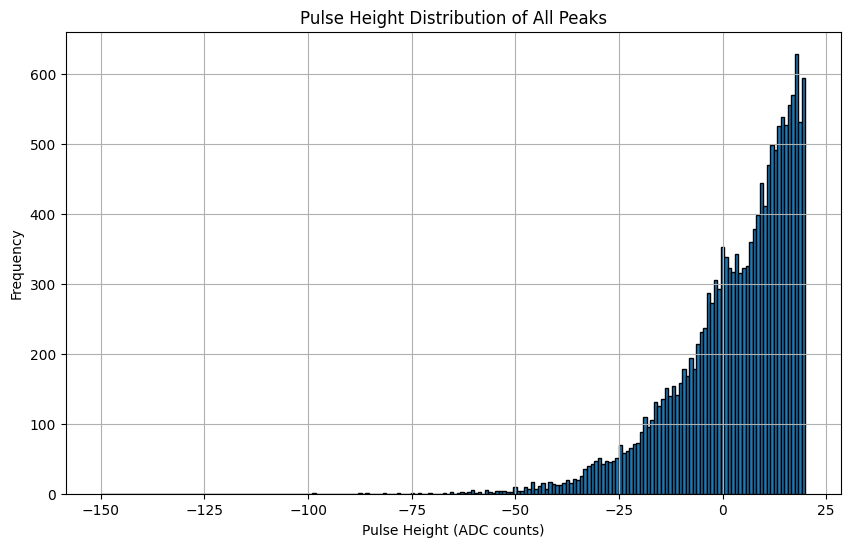

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(final_results_df['pulse_height'], bins=200, edgecolor = 'black', range=(-150, 20))
plt.xlabel("Pulse Height (ADC counts)")
plt.ylabel("Frequency")
plt.title("Pulse Height Distribution of All Peaks")
plt.grid(True)
plt.show()

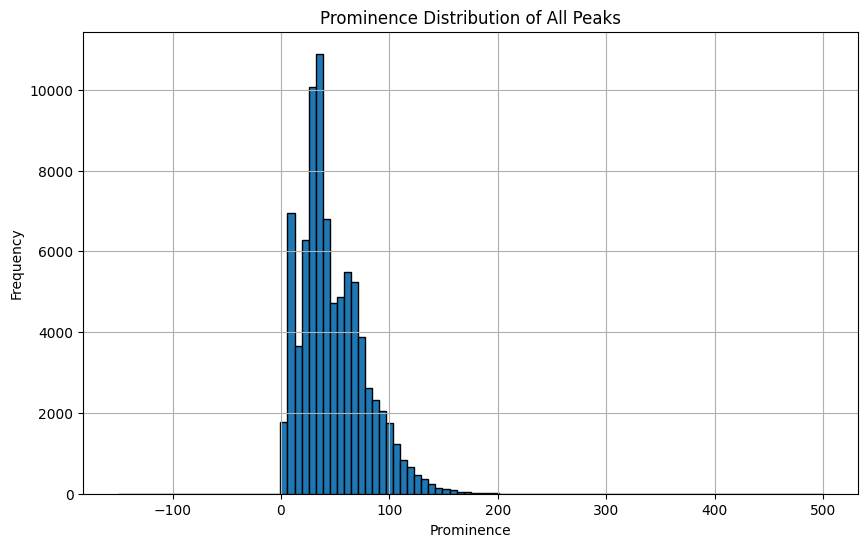

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(final_results_df['prominence'], bins=100, edgecolor = 'black', range=(-150, 500))
plt.xlabel("Prominence")
plt.ylabel("Frequency")
plt.title("Prominence Distribution of All Peaks")
plt.grid(True)
plt.show()

In [ ]:
from google.colab import files
from IPython.display import Image

# Please upload 'example_midas_waveform.jpg'
uploaded = files.upload()

Image(filename='example_midas_waveform.jpg')

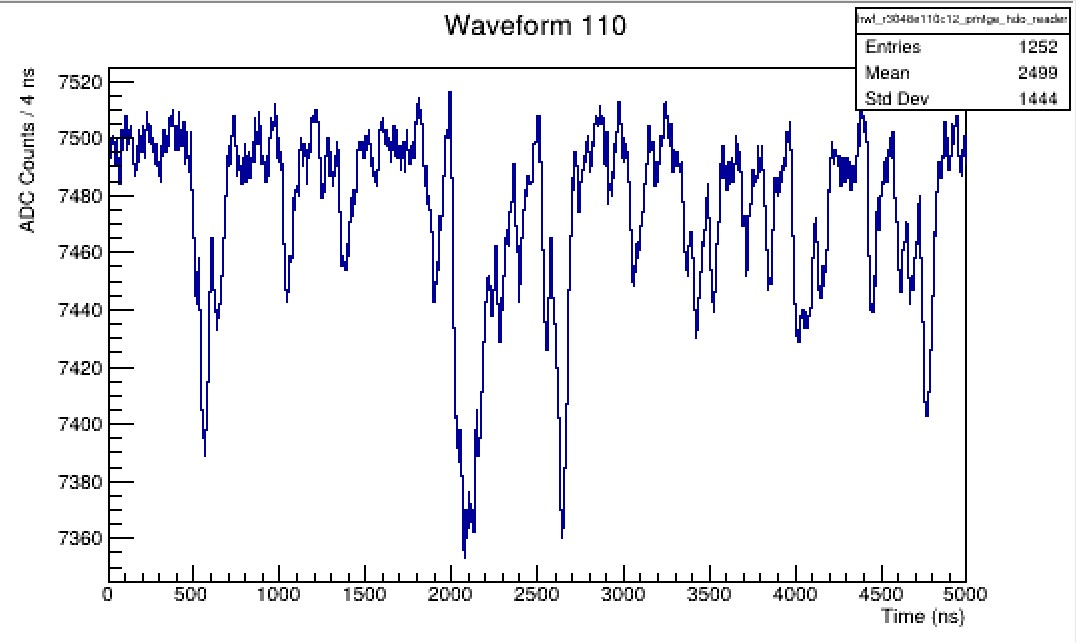

In [ ]:
from IPython.display import Image
Image(filename='example_midas_waveform.jpg')

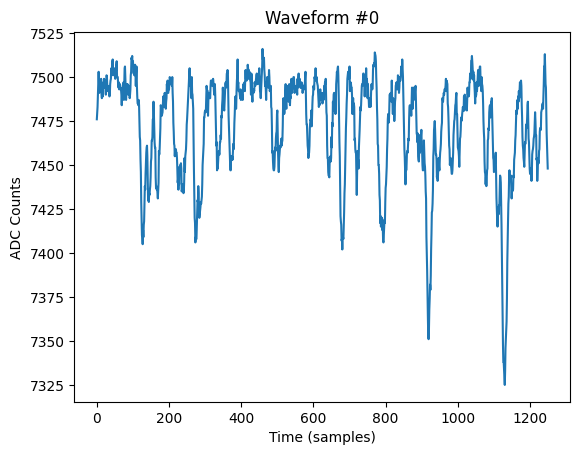

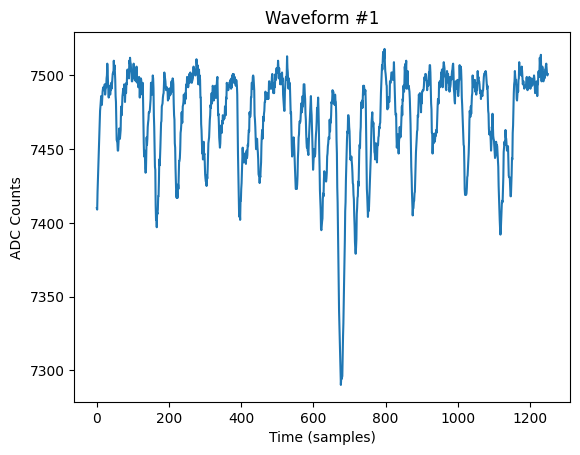

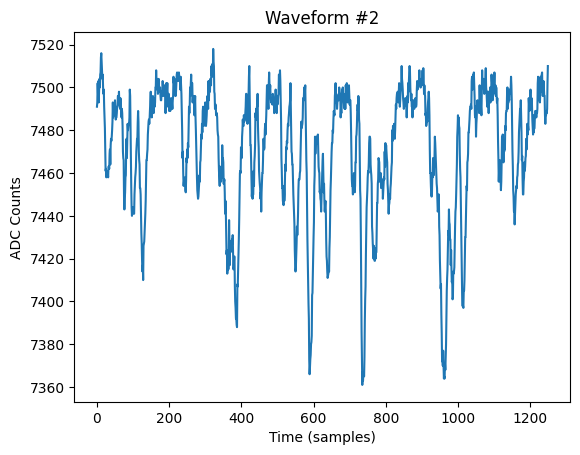

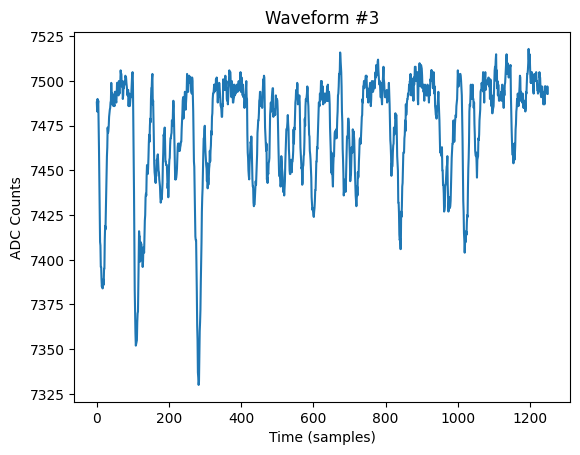

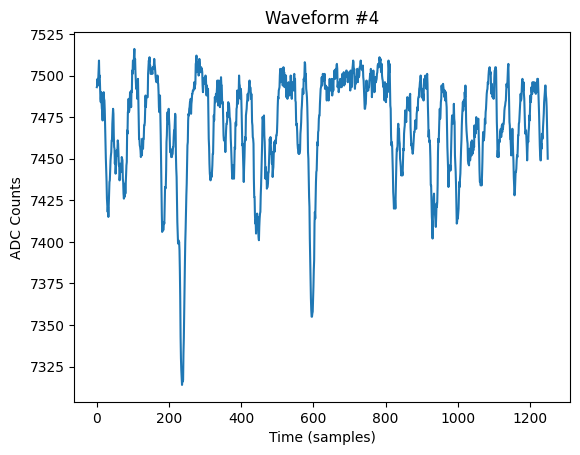

In [ ]:
import matplotlib.pyplot as plt

with uproot.open(file_path) as file:
    keys = file.keys()
    for i in range(5):
        waveform_np = file[keys[i]].values()
        plt.plot(waveform_np)
        plt.title(f"Waveform #{i}")
        plt.xlabel("Time (samples)")
        plt.ylabel("ADC Counts")
        plt.show()

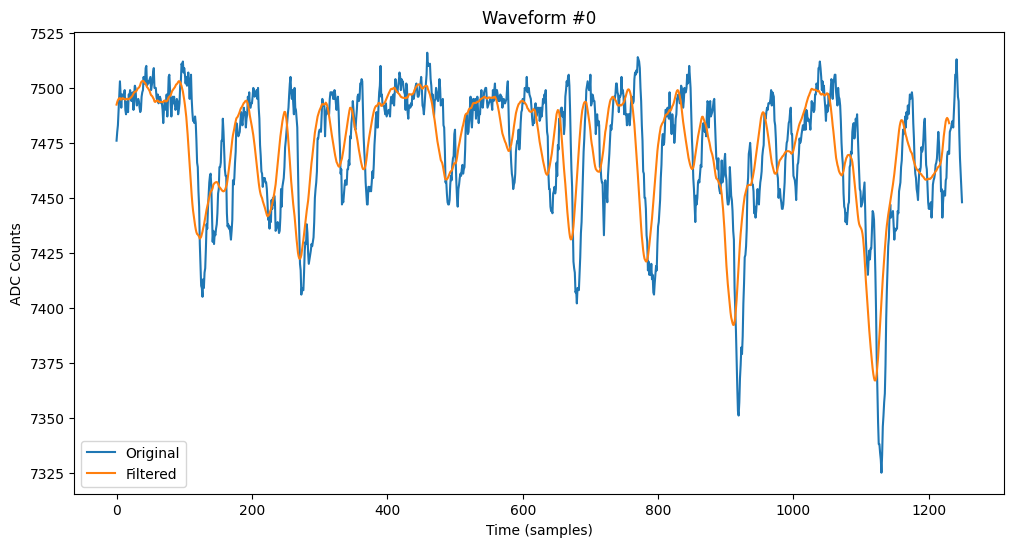

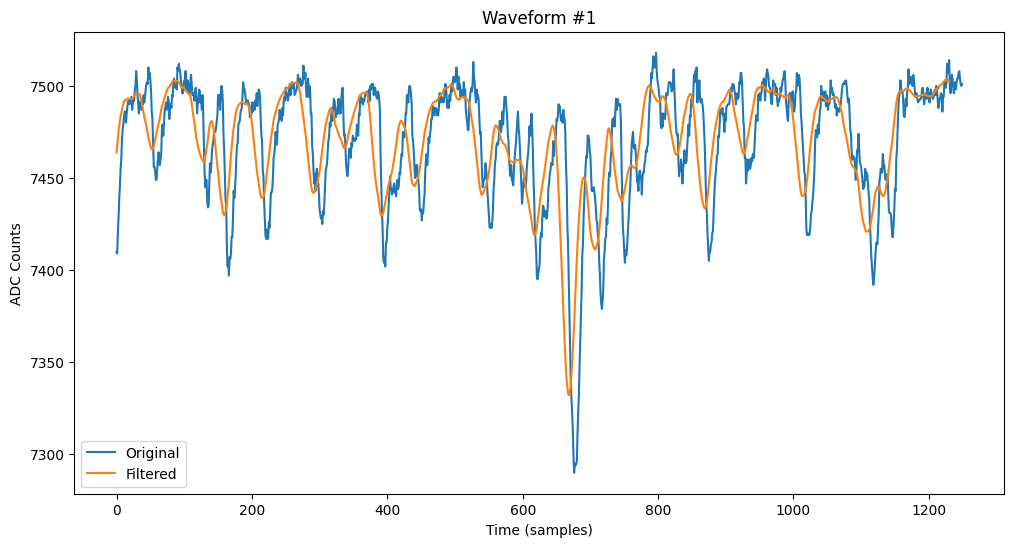

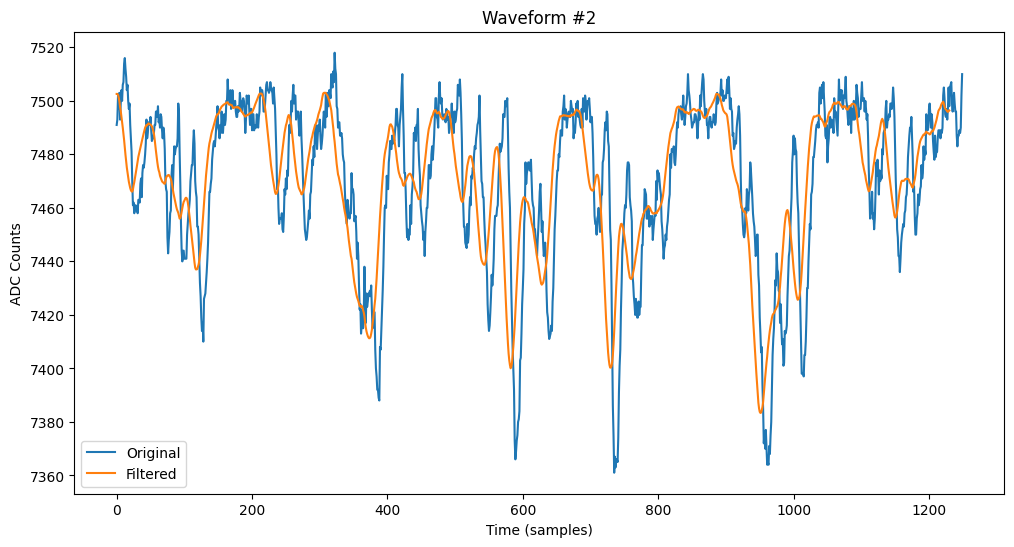

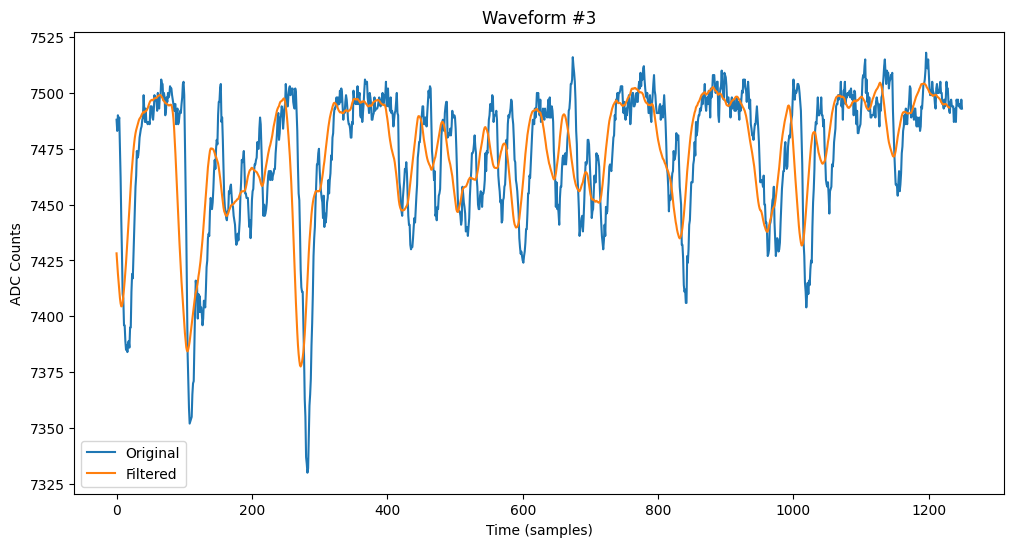

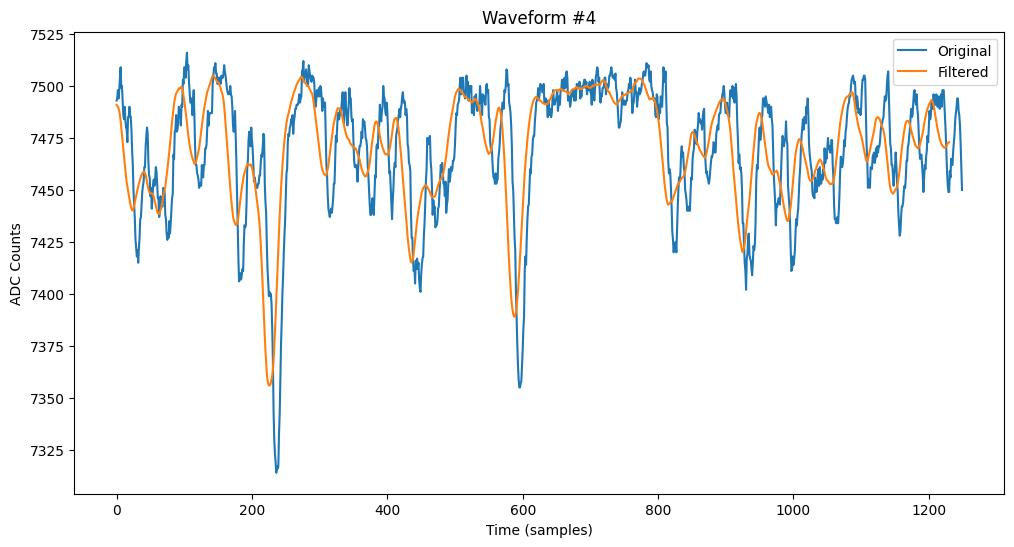

In [ ]:
import matplotlib.pyplot as plt

with uproot.open(file_path) as file:
    keys = file.keys()
    for i in range(5):
        waveform_np = file[keys[i]].values()
        filtered_waveform = moving_average(waveform_np, moving_average_window_size)

        plt.figure(figsize=(12, 6))
        plt.plot(waveform_np, label='Original')
        plt.plot(filtered_waveform, label='Filtered')
        plt.title(f"Waveform #{i}")
        plt.xlabel("Time (samples)")
        plt.ylabel("ADC Counts")
        plt.legend()
        plt.show()

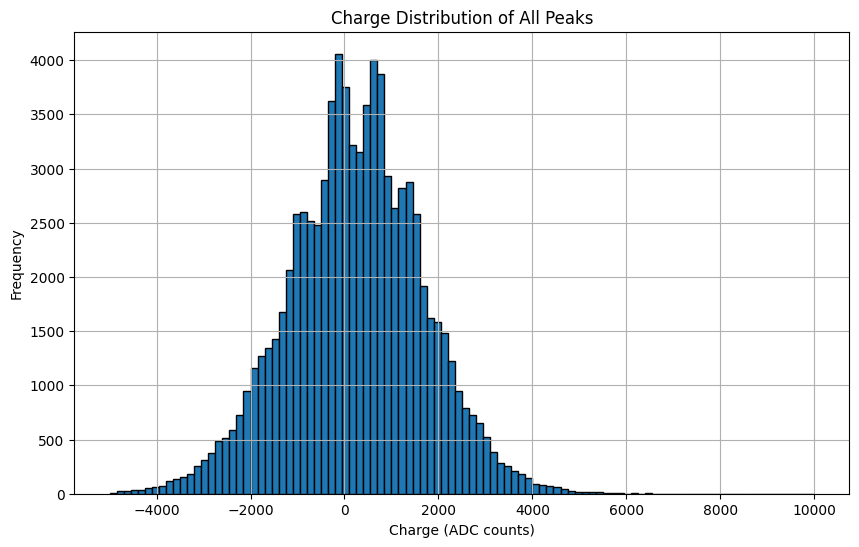

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(final_results_df['charge'], bins=100, edgecolor = 'black', range=(-5000, 10000))
plt.xlabel("Charge (ADC counts)")
plt.ylabel("Frequency")
plt.title("Charge Distribution of All Peaks")
plt.grid(True)
plt.show()

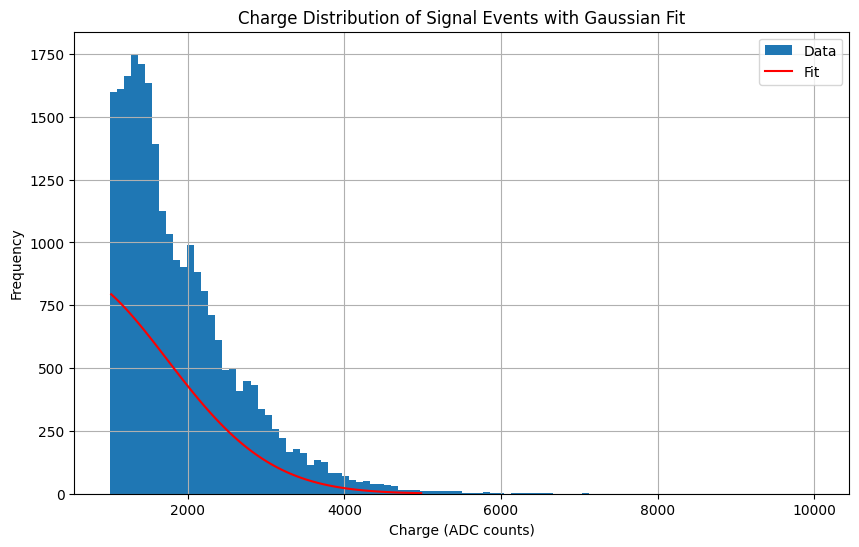

Fit parameters: amp=884.41, mean=404.29, stddev=1324.21


In [ ]:
from scipy.optimize import curve_fit
from scipy.stats import norm

# Define the Gaussian function
def gaussian(x, amp, mean, stddev):
    return amp * np.exp(-((x - mean) / stddev)**2 / 2)

# Get the histogram data
hist, bin_edges = np.histogram(charge_cut_df['charge'], bins=100, range=(1000, 5000))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Fit the Gaussian to the data
popt, pcov = curve_fit(gaussian, bin_centers, hist, p0=[1800, 2500, 500])

# Plot the histogram and the fit
plt.figure(figsize=(10, 6))
plt.hist(charge_cut_df['charge'], bins=100, range=(1000, 10000), label='Data')
plt.plot(bin_centers, gaussian(bin_centers, *popt), 'r-', label='Fit')
plt.xlabel("Charge (ADC counts)")
plt.ylabel("Frequency")
plt.title("Charge Distribution of Signal Events with Gaussian Fit")
plt.legend()
plt.grid(True)
plt.show()

# Print the fit parameters
print(f"Fit parameters: amp={popt[0]:.2f}, mean={popt[1]:.2f}, stddev={popt[2]:.2f}")

In [ ]:
pulse_prominence_df = final_results_df[['pulse_height', 'prominence']]
display(pulse_prominence_df.head())